
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fblaura/FraudD/blob/main/2_AutoML/1_AutoML_for_dataset_passed_through_StandardScaler_and_SMOTE_imbalance_of_0_05.ipynb)

 **Please make sure to install the following libraries in order for the entire notebook to work.**

AutoML H20 is a process that assists in the selection of training models, which compares the performance of models by comparing metrics, which are then reflected in a leaderboard. In order to get an initial idea of which supervised or unsupervised models are ideal for our case (fraud detection) this type of training is used. The data used for this exercise is coded, preprocessed and passed through a technique to adjust the unequal distribution of the classes of the dataset, this technique is called SMOTE (Synthetic Minority Over-sampling Technique), as a rate to adjust the imbalance is chosen: **0.05**. Inside the folder you will find AutoML executions for different scaling methods and SMOTE rates. 


# **1. Libraries Installation**

In [1]:
! pip install requests
! pip install tabulate
! pip install "colorama>=0.3.8"
! pip install future

In [2]:
!pip install gdown

In [3]:
! pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 175.8 MB 20 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=5063fce24cde556ac04a8a02d1f4cbf2d088afec0b0275632a0eec43e1ff36c7
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from pandas_profiling import ProfileReport
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer, StandardScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, validation_curve 
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
from google.colab import files

In [6]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from datetime import datetime
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib.pylab import rcParams
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, roc_curve,precision_score,roc_auc_score

# **2. h2o initialization**

In [7]:
import h2o
from h2o.automl import H2OAutoML


In [8]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp247m40lo
  JVM stdout: /tmp/tmp247m40lo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp247m40lo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_rvk944
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# **3. Dataset initialization**

Due to the size of the dataset it is not possible to download the file from Github, as an alternative a link is used to download the dataset from Drive. ***Remember that this dataset is no longer a representation of the raw data due to its previous preprocessing.*** 

In [7]:
#train_fill
!gdown --id 1HS9g0Fk2Vx-t_gO_OB72AOh3gxnYsBYl

Downloading...
From: https://drive.google.com/uc?id=1HS9g0Fk2Vx-t_gO_OB72AOh3gxnYsBYl
To: /content/X_trainss_005.csv
100% 656M/656M [00:04<00:00, 147MB/s]


In [8]:
X_trainss_005 = pd.read_csv('/content/X_trainss_005.csv')

In [9]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

We can observe that the distribution of classes within the dataset being worked on is quite unbiased. We have that for the class representing the existence of 'No fraud' there is a presence of 95.2% of cases, while for the positive event 'Fraud' there are only 4.76% cases. This distribution of data is given after applying the SMOTE imbalance technique with a rate of 0.05.

In [10]:
counting=X_trainss_005['isFraud'].value_counts().values
pieplot=pd.DataFrame([[counting[0], 'NoFraud'], [counting[1], 'Fraud']],columns=['Count of cases', 'Events'])

In [11]:
fig = px.pie(pieplot, values='Count of cases', names='Events', title='Distribution of imbalanced classes')
fig.show()

# **4. AutoML for dataset with StandardScaler scaling and imbalance with SMOTE 0.05 and classification metrics**

The training process with AutoML is then initiated, the task is defined as a classification problem. The conversion from Pandas Dataframe to H2O dataframe is made in order to start the automatic process; the leaderboard and the best models are called. 

Different notebooks are created due to the RAM consumption generated by the conversion from Pandas to H20 driven by the volume of the dataset. Recall also that the original Kaggle competition dataset has approximately 590.000 rows, while this notebook works with a partition representing one eighth of the data. 

In [54]:
hftrainss_005 = h2o.H2OFrame(X_trainss_005)
#hftest =h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [55]:
trainss_005, testss_005 = hftrainss_005.split_frame(ratios=[.7]) #mirar en diferentes proporciones 70/30 ... 

In [56]:
xss_005 = trainss_005.columns
yss_005 = "isFraud"
xss_005.remove(yss_005)

In [57]:
trainss_005[yss_005] = trainss_005[yss_005].asfactor()


Run AutoML for 15 base models

In [58]:
#  
aml = H2OAutoML(max_runtime_secs = 3600*5, max_models=15, seed=1) 
#
aml.train(x=xss_005, y=yss_005, training_frame=trainss_005)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20211010_163911,0.972772,0.0493866,0.894455,0.104569,0.105944,0.0112242
StackedEnsemble_AllModels_3_AutoML_1_20211010_163911,0.972764,0.0494148,0.894357,0.105483,0.105976,0.0112309
StackedEnsemble_AllModels_2_AutoML_1_20211010_163911,0.972729,0.0494159,0.89438,0.104983,0.105978,0.0112313
StackedEnsemble_BestOfFamily_2_AutoML_1_20211010_163911,0.972323,0.0497813,0.893549,0.104089,0.106074,0.0112518
StackedEnsemble_BestOfFamily_3_AutoML_1_20211010_163911,0.972323,0.0498028,0.893473,0.103912,0.106135,0.0112647
StackedEnsemble_BestOfFamily_7_AutoML_1_20211010_163911,0.972243,0.0636904,0.892105,0.099818,0.120801,0.0145929
StackedEnsemble_BestOfFamily_4_AutoML_1_20211010_163911,0.972207,0.050196,0.892464,0.107898,0.106931,0.0114343
StackedEnsemble_BestOfFamily_1_AutoML_1_20211010_163911,0.972048,0.0501411,0.892543,0.100688,0.106621,0.0113681
GBM_1_AutoML_1_20211010_163911,0.971603,0.0541004,0.890987,0.100571,0.111685,0.0124736
StackedEnsemble_AllModels_6_AutoML_1_20211010_163911,0.971405,0.0839624,0.890369,0.108495,0.141939,0.0201467


With the use of `extra_columns` is possible to obtain de timen information regarding each trained model



In [59]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20211010_163911,0.972772,0.0493866,0.894455,0.104569,0.105944,0.0112242,13199,0.218944,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211010_163911,0.972764,0.0494148,0.894357,0.105483,0.105976,0.0112309,17289,0.24369,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211010_163911,0.972729,0.0494159,0.89438,0.104983,0.105978,0.0112313,14030,0.209959,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20211010_163911,0.972323,0.0497813,0.893549,0.104089,0.106074,0.0112518,14995,0.117999,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20211010_163911,0.972323,0.0498028,0.893473,0.103912,0.106135,0.0112647,15019,0.125067,StackedEnsemble
StackedEnsemble_BestOfFamily_7_AutoML_1_20211010_163911,0.972243,0.0636904,0.892105,0.099818,0.120801,0.0145929,57372,0.085048,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_1_20211010_163911,0.972207,0.050196,0.892464,0.107898,0.106931,0.0114343,13572,0.108238,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20211010_163911,0.972048,0.0501411,0.892543,0.100688,0.106621,0.0113681,12159,0.10113,StackedEnsemble
GBM_1_AutoML_1_20211010_163911,0.971603,0.0541004,0.890987,0.100571,0.111685,0.0124736,724335,0.129393,GBM
StackedEnsemble_AllModels_6_AutoML_1_20211010_163911,0.971405,0.0839624,0.890369,0.108495,0.141939,0.0201467,37805,0.181876,StackedEnsemble


And as well we can obtain information about the leader model

In [61]:
# Get the best model using the metric
m = aml.leader
m

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_1_20211010_163911

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0013316755090644432
RMSE: 0.036492129412579406
LogLoss: 0.010754126370640542
Null degrees of freedom: 9938
Residual degrees of freedom: 9933
Null deviance: 3827.836034451953
Residual deviance: 213.7705239955927
AIC: 225.7705239955927
AUC: 0.9999454953212386
AUCPR: 0.9991274449918954
Gini: 0.9998909906424771

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35807908982453585: 


,,0,1,Error,Rate
0,0,9460.0,2.0,0.0002,(2.0/9462.0)
1,1,4.0,473.0,0.0084,(4.0/477.0)
2,Total,9464.0,475.0,0.0006,(6.0/9939.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.358079,0.993697,124.0
1,max f2,0.296313,0.992462,129.0
2,max f0point5,0.510653,0.996169,117.0
3,max accuracy,0.358079,0.999396,124.0
4,max precision,0.999939,1.000000,0.0
5,max recall,0.067194,1.000000,209.0
6,max specificity,0.999939,1.000000,0.0
7,max absolute_mcc,0.358079,0.993383,124.0
8,max min_per_class_accuracy,0.142875,0.996090,155.0
9,max mean_per_class_accuracy,0.142875,0.996997,155.0



Gains/Lift Table: Avg response rate:  4.80 %, avg score:  5.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010061,0.999398,20.836478,20.836478,1.000000,0.999780,1.000000,0.999780,0.209644,0.209644,1983.647799,1983.647799,0.209644
1,2,0.020022,0.997824,20.836478,20.836478,1.000000,0.998729,1.000000,0.999257,0.207547,0.417191,1983.647799,1983.647799,0.417191
2,3,0.030084,0.988655,20.836478,20.836478,1.000000,0.994483,1.000000,0.997660,0.209644,0.626834,1983.647799,1983.647799,0.626834
3,4,0.040044,0.922383,20.836478,20.836478,1.000000,0.969331,1.000000,0.990614,0.207547,0.834382,1983.647799,1983.647799,0.834382
4,5,0.050005,0.183571,15.995680,19.872214,0.767677,0.643479,0.953722,0.921466,0.159329,0.993711,1499.568007,1887.221442,0.991280
5,6,0.100010,0.028590,0.125774,9.998994,0.006036,0.058952,0.479879,0.490209,0.006289,1.000000,-87.422649,899.899396,0.945360
6,7,0.150015,0.015010,0.000000,6.665996,0.000000,0.020750,0.319920,0.333723,0.000000,1.000000,-100.000000,566.599598,0.892834
7,8,0.200020,0.009878,0.000000,4.999497,0.000000,0.012190,0.239940,0.253339,0.000000,1.000000,-100.000000,399.949698,0.840309
8,9,0.300030,0.005361,0.000000,3.332998,0.000000,0.007306,0.159960,0.171328,0.000000,1.000000,-100.000000,233.299799,0.735257
9,10,0.400040,0.003435,0.000000,2.499748,0.000000,0.004311,0.119970,0.129574,0.000000,1.000000,-100.000000,149.974849,0.630205




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.011224177210971088
RMSE: 0.10594421744942518
LogLoss: 0.04938662081142964
Null degrees of freedom: 52191
Residual degrees of freedom: 52186
Null deviance: 20299.828554556945
Residual deviance: 5155.173026780271
AIC: 5167.173026780271
AUC: 0.9727722101719312
AUCPR: 0.8944547323193481
Gini: 0.9455444203438623

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40114222497633273: 


,,0,1,Error,Rate
0,0,49482.0,172.0,0.0035,(172.0/49654.0)
1,1,522.0,2016.0,0.2057,(522.0/2538.0)
2,Total,50004.0,2188.0,0.0133,(694.0/52192.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.401142,0.853153,155.0
1,max f2,0.171810,0.836951,227.0
2,max f0point5,0.683204,0.912488,96.0
3,max accuracy,0.414815,0.986722,152.0
4,max precision,0.999811,1.000000,0.0
5,max recall,0.000140,1.000000,399.0
6,max specificity,0.999811,1.000000,0.0
7,max absolute_mcc,0.414815,0.848815,152.0
8,max min_per_class_accuracy,0.028485,0.921592,324.0
9,max mean_per_class_accuracy,0.071692,0.930923,284.0



Gains/Lift Table: Avg response rate:  4.86 %, avg score:  4.86 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.998976,20.564224,20.564224,1.000000,0.999644,1.000000,0.999644,0.205674,0.205674,1956.422380,1956.422380,0.205674
1,2,0.020003,0.992628,20.446039,20.505131,0.994253,0.996734,0.997126,0.998189,0.204492,0.410165,1944.603860,1950.513120,0.410105
2,3,0.030005,0.929152,20.052088,20.354117,0.975096,0.973914,0.989783,0.990098,0.200552,0.610717,1905.208796,1935.411679,0.610395
3,4,0.040006,0.503153,16.270162,19.333128,0.791188,0.747155,0.940134,0.929362,0.162727,0.773444,1527.016174,1833.312802,0.770926
4,5,0.050008,0.198063,6.618371,16.790177,0.321839,0.311992,0.816475,0.805888,0.066194,0.839638,561.837088,1579.017660,0.829991
5,6,0.100015,0.038515,1.402464,9.096320,0.068199,0.082348,0.442337,0.444118,0.070134,0.909771,40.246431,809.632045,0.851146
6,7,0.150004,0.018800,0.496568,6.230469,0.024147,0.026594,0.302976,0.304979,0.024823,0.934594,-50.343193,523.046862,0.824694
7,8,0.200011,0.011781,0.283644,4.743620,0.013793,0.014840,0.230673,0.232437,0.014184,0.948779,-71.635553,374.362017,0.787039
8,9,0.300008,0.006133,0.185192,3.224241,0.009006,0.008510,0.156789,0.157800,0.018519,0.967297,-81.480772,222.424125,0.701397
9,10,0.400004,0.003711,0.074865,2.436935,0.003641,0.004797,0.118504,0.119551,0.007486,0.974783,-92.513504,143.693489,0.604159


And for other models that may be of interest to us

In [66]:
# Get the best XGBoost model using default sort metric
xgb = aml.get_best_model(algorithm="xgboost")
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_1_20211010_163911_model_1


Model Summary: 


,,number_of_trees
0,,84.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.005443737932508137
RMSE: 0.07378169103855059
LogLoss: 0.02492962895475104
Mean Per-Class Error: 0.020682944732473896
AUC: 0.9974861661293473
AUCPR: 0.9821903395237936
Gini: 0.9949723322586945

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24243299450193131: 


,,0,1,Error,Rate
0,0,49562.0,92.0,0.0019,(92.0/49654.0)
1,1,156.0,2382.0,0.0615,(156.0/2538.0)
2,Total,49718.0,2474.0,0.0048,(248.0/52192.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.242433,0.950519,207.0
1,max f2,0.158189,0.947356,232.0
2,max f0point5,0.424977,0.973299,170.0
3,max accuracy,0.316945,0.995306,189.0
4,max precision,0.999666,1.000000,0.0
5,max recall,0.001499,1.000000,389.0
6,max specificity,0.999666,1.000000,0.0
7,max absolute_mcc,0.316945,0.948221,189.0
8,max min_per_class_accuracy,0.070198,0.977686,278.0
9,max mean_per_class_accuracy,0.084133,0.979317,268.0



Gains/Lift Table: Avg response rate:  4.86 %, avg score:  4.88 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.996037,20.564224,20.564224,1.000000,0.998756,1.000000,0.998756,0.205674,0.205674,1956.422380,1956.422380,0.205674
1,2,0.020003,0.974563,20.564224,20.564224,1.000000,0.987863,1.000000,0.993310,0.205674,0.411348,1956.422380,1956.422380,0.411348
2,3,0.030005,0.890851,20.564224,20.564224,1.000000,0.944208,1.000000,0.976942,0.205674,0.617021,1956.422380,1956.422380,0.617021
3,4,0.040006,0.608100,20.564224,20.564224,1.000000,0.775322,1.000000,0.926537,0.205674,0.822695,1956.422380,1956.422380,0.822695
4,5,0.050008,0.176706,12.842791,19.019937,0.624521,0.358396,0.924904,0.812909,0.128448,0.951143,1184.279111,1801.993726,0.947195
5,6,0.100015,0.035902,0.756385,9.888161,0.036782,0.069943,0.480843,0.441426,0.037825,0.988968,-24.361476,888.816125,0.934390
6,7,0.150004,0.020150,0.110348,6.629723,0.005366,0.026769,0.322391,0.303242,0.005516,0.994484,-88.965154,562.972294,0.887645
7,8,0.200011,0.013241,0.055153,4.985923,0.002682,0.016306,0.242456,0.231501,0.002758,0.997242,-94.484691,398.592302,0.837980
8,9,0.300008,0.007219,0.011821,3.327995,0.000575,0.009782,0.161834,0.157599,0.001182,0.998424,-98.817922,232.799483,0.734115
9,10,0.400004,0.004480,0.003940,2.497021,0.000192,0.005716,0.121425,0.119630,0.000394,0.998818,-99.605974,149.702100,0.629422




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.014698926357668505
RMSE: 0.12123912882262271
LogLoss: 0.06244326676033186
Mean Per-Class Error: 0.08652477191019226
AUC: 0.9625989110206061
AUCPR: 0.8529280241327274
Gini: 0.9251978220412123

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29710572957992554: 


,,0,1,Error,Rate
0,0,49405.0,249.0,0.005,(249.0/49654.0)
1,1,672.0,1866.0,0.2648,(672.0/2538.0)
2,Total,50077.0,2115.0,0.0176,(921.0/52192.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.297106,0.802063,183.0
1,max f2,0.129451,0.795498,246.0
2,max f0point5,0.538411,0.880004,131.0
3,max accuracy,0.437603,0.982967,151.0
4,max precision,0.999848,1.000000,0.0
5,max recall,0.000295,1.000000,398.0
6,max specificity,0.999848,1.000000,0.0
7,max absolute_mcc,0.431662,0.800221,153.0
8,max min_per_class_accuracy,0.025297,0.902405,331.0
9,max mean_per_class_accuracy,0.048483,0.913475,302.0



Gains/Lift Table: Avg response rate:  4.86 %, avg score:  4.43 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.993007,20.564224,20.564224,1.000000,0.998007,1.000000,0.998007,0.205674,0.205674,1956.422380,1956.422380,0.205674
1,2,0.020003,0.951321,20.327853,20.446039,0.988506,0.977391,0.994253,0.987699,0.203310,0.408983,1932.785341,1944.603860,0.408863
2,3,0.030005,0.703391,19.264187,20.052088,0.936782,0.864188,0.975096,0.946529,0.192671,0.601655,1826.418666,1905.208796,0.600869
3,4,0.040006,0.307570,12.842791,18.249764,0.624521,0.495364,0.887452,0.833737,0.128448,0.730102,1184.279111,1724.976374,0.725370
4,5,0.050008,0.161886,6.382000,15.876211,0.310345,0.223187,0.772031,0.711627,0.063830,0.793932,538.200049,1487.621109,0.781949
5,6,0.100015,0.040517,1.741262,8.808736,0.084674,0.076621,0.428352,0.394124,0.087076,0.881009,74.126186,780.873648,0.820913
6,7,0.150004,0.021666,0.599034,6.072868,0.029130,0.029412,0.295312,0.272584,0.029945,0.910954,-40.096550,507.286824,0.799845
7,8,0.200011,0.014024,0.433346,4.662853,0.021073,0.017429,0.226746,0.208789,0.021671,0.932624,-56.665429,366.285255,0.770059
8,9,0.300008,0.007327,0.177312,3.167768,0.008622,0.010089,0.154043,0.142560,0.017730,0.950355,-82.268824,216.776777,0.683589
9,10,0.400004,0.004447,0.169431,2.418220,0.008239,0.005723,0.117594,0.108353,0.016942,0.967297,-83.056876,141.821954,0.596290




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.983158,0.000600,0.983715,0.982757,0.983905,0.982755,0.982660
1,auc,0.962830,0.006822,0.955836,0.970686,0.966625,0.955489,0.965515
2,err,0.016842,0.000600,0.016285,0.017243,0.016095,0.017245,0.017340
3,err_count,175.800000,6.260990,170.000000,180.000000,168.000000,180.000000,181.000000
4,f0point5,0.866543,0.007916,0.876261,0.855757,0.866762,0.871408,0.862528
5,f1,0.806917,0.007296,0.795181,0.811716,0.812081,0.804348,0.811262
6,f2,0.755266,0.017936,0.727834,0.771986,0.763889,0.746871,0.765748
7,lift_top_group,20.590952,0.837950,21.793320,20.113680,21.129555,20.111753,19.806452
8,logloss,0.062443,0.004273,0.062782,0.059947,0.056892,0.068052,0.064543
9,max_per_class_error,0.275521,0.023585,0.311065,0.252408,0.265182,0.287091,0.261860



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-10 21:25:03,6 min 53.051 sec,0.0,0.500000,0.693147,0.500000,0.048628,1.000000,0.951372
1,,2021-10-10 21:25:10,7 min 0.135 sec,5.0,0.182714,0.174437,0.900341,0.699636,20.524904,0.025770
2,,2021-10-10 21:25:15,7 min 5.125 sec,10.0,0.142689,0.097828,0.938688,0.781056,20.564224,0.021114
3,,2021-10-10 21:25:20,7 min 10.156 sec,15.0,0.128017,0.072988,0.963320,0.842575,20.564224,0.017781
4,,2021-10-10 21:25:28,7 min 18.162 sec,20.0,0.120044,0.062450,0.973984,0.874815,20.564224,0.015596
5,,2021-10-10 21:25:34,7 min 23.641 sec,25.0,0.113778,0.055805,0.979406,0.896606,20.564224,0.013929
6,,2021-10-10 21:25:39,7 min 28.931 sec,30.0,0.107926,0.050099,0.984311,0.915165,20.564224,0.012435
7,,2021-10-10 21:25:44,7 min 34.286 sec,35.0,0.103032,0.045844,0.986563,0.926873,20.564224,0.011496
8,,2021-10-10 21:25:49,7 min 39.389 sec,40.0,0.098511,0.041990,0.989172,0.938744,20.564224,0.010078
9,,2021-10-10 21:25:55,7 min 44.577 sec,45.0,0.095279,0.039538,0.990352,0.946218,20.564224,0.009254



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C13,1012.240173,1.000000,0.048397
1,V294,829.374573,0.819346,0.039654
2,C14,741.885742,0.732915,0.035471
3,card6,703.000854,0.694500,0.033612
4,card1,642.443970,0.634675,0.030717
5,C12,565.325439,0.558489,0.027029
6,card2,555.928528,0.549206,0.026580
7,V258,527.593872,0.521214,0.025225
8,TransactionAmt,513.812927,0.507600,0.024566
9,TransactionID,471.122620,0.465426,0.022525



See the whole table with table.as_data_frame()


We can also generate a printout of the specific parameters of a certain model. Based on this information we can define some arguments of our classification model, in this case, with supervised classification methods. 

In [103]:
xgradboost=xgb.params.keys()
for keys in xgradboost:
  print(keys,xgb.params[keys])

model_id {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'XGBoost_grid_1_AutoML_1_20211010_163911_model_1', 'type': 'Key<Model>', 'URL': '/3/Models/XGBoost_grid_1_AutoML_1_20211010_163911_model_1'}, 'input': None}
training_frame {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_163911_training_py_4_sid_b8ef', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_163911_training_py_4_sid_b8ef'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_163911_training_py_4_sid_b8ef', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_163911_training_py_4_sid_b8ef'}}
validation_frame {'default': None, 'actual': None, 'input': None}
nfolds {'default': 0, 'actual': 5, 'input': 5}
keep_cross_validation_models {'default': True, 'actual': 

In [68]:
gbm = aml.get_best_model(algorithm="GBM")
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_1_20211010_163911


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,201.0,201.0,306323.0,15.0,15.0,15.0,35.0,234.0,115.8408




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.001389978611540638
RMSE: 0.03728241692193034
LogLoss: 0.009022748517170272
Mean Per-Class Error: 0.0009938038364964985
AUC: 0.9999884107400675
AUCPR: 0.9998099953835908
Gini: 0.999976821480135

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2015564955228502: 


,,0,1,Error,Rate
0,0,49648.0,6.0,0.0001,(6.0/49654.0)
1,1,10.0,2528.0,0.0039,(10.0/2538.0)
2,Total,49658.0,2534.0,0.0003,(16.0/52192.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.201556,0.996845,235.0
1,max f2,0.164801,0.997007,241.0
2,max f0point5,0.267661,0.998177,228.0
3,max accuracy,0.205951,0.999693,234.0
4,max precision,0.999835,1.000000,0.0
5,max recall,0.035599,1.000000,300.0
6,max specificity,0.999835,1.000000,0.0
7,max absolute_mcc,0.201556,0.996685,235.0
8,max min_per_class_accuracy,0.121349,0.998818,250.0
9,max mean_per_class_accuracy,0.121349,0.999006,250.0



Gains/Lift Table: Avg response rate:  4.86 %, avg score:  4.85 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.996331,20.564224,20.564224,1.000000,0.998576,1.000000,0.998576,0.205674,0.205674,1956.422380,1956.422380,0.205674
1,2,0.020003,0.986995,20.564224,20.564224,1.000000,0.992472,1.000000,0.995524,0.205674,0.411348,1956.422380,1956.422380,0.411348
2,3,0.030005,0.954988,20.564224,20.564224,1.000000,0.973921,1.000000,0.988323,0.205674,0.617021,1956.422380,1956.422380,0.617021
3,4,0.040006,0.863501,20.564224,20.564224,1.000000,0.919364,1.000000,0.971083,0.205674,0.822695,1956.422380,1956.422380,0.822695
4,5,0.050008,0.102304,17.609594,19.973298,0.856322,0.598312,0.971264,0.896529,0.176123,0.998818,1660.959394,1897.329783,0.997308
5,6,0.100015,0.015307,0.023637,9.998467,0.001149,0.031396,0.486207,0.463962,0.001182,1.000000,-97.636296,899.846743,0.945986
6,7,0.150004,0.008563,0.000000,6.666496,0.000000,0.011326,0.324179,0.313122,0.000000,1.000000,-100.000000,566.649636,0.893443
7,8,0.200011,0.005719,0.000000,4.999713,0.000000,0.006961,0.243127,0.236575,0.000000,1.000000,-100.000000,399.971262,0.840879
8,9,0.300008,0.003225,0.000000,3.333248,0.000000,0.004287,0.162090,0.159150,0.000000,1.000000,-100.000000,233.324818,0.735772
9,10,0.400004,0.002055,0.000000,2.499976,0.000000,0.002579,0.121569,0.120009,0.000000,1.000000,-100.000000,149.997605,0.630664




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.012473612557742476
RMSE: 0.11168532830118053
LogLoss: 0.05410035863233719
Mean Per-Class Error: 0.07066599052995981
AUC: 0.9716028613831195
AUCPR: 0.8909870822377526
Gini: 0.9432057227662389

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1891020593839132: 


,,0,1,Error,Rate
0,0,49429.0,225.0,0.0045,(225.0/49654.0)
1,1,499.0,2039.0,0.1966,(499.0/2538.0)
2,Total,49928.0,2264.0,0.0139,(724.0/52192.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.189102,0.849229,232.0
1,max f2,0.108247,0.836535,267.0
2,max f0point5,0.423929,0.910334,173.0
3,max accuracy,0.355856,0.986550,189.0
4,max precision,0.999621,1.000000,0.0
5,max recall,0.000111,1.000000,399.0
6,max specificity,0.999621,1.000000,0.0
7,max absolute_mcc,0.355856,0.844885,189.0
8,max min_per_class_accuracy,0.015732,0.920410,346.0
9,max mean_per_class_accuracy,0.031740,0.929334,322.0



Gains/Lift Table: Avg response rate:  4.86 %, avg score:  4.04 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,9.936890e-01,20.564224,20.564224,1.000000,0.997627,1.000000,0.997627,0.205674,0.205674,1956.422380,1956.422380,0.205674
1,2,0.020003,9.626876e-01,20.367248,20.465736,0.990421,0.982065,0.995211,0.989846,0.203704,0.409377,1936.724847,1946.573614,0.409277
2,3,0.030005,7.875161e-01,20.091483,20.340985,0.977011,0.901854,0.989144,0.960515,0.200946,0.610323,1909.148302,1934.098510,0.609981
3,4,0.040006,2.843136e-01,15.994396,19.254338,0.777778,0.531869,0.936303,0.853354,0.159968,0.770292,1499.439629,1825.433790,0.767613
4,5,0.050008,1.053814e-01,7.051717,16.813814,0.342912,0.170920,0.817625,0.716867,0.070528,0.840820,605.171659,1581.381363,0.831233
5,6,0.100015,2.075109e-02,1.402464,9.108139,0.068199,0.043733,0.442912,0.380300,0.070134,0.910954,40.246431,810.813897,0.852388
6,7,0.150004,1.051437e-02,0.394102,6.204202,0.019164,0.014753,0.301699,0.258482,0.019701,0.930654,-60.589836,520.420189,0.820552
7,8,0.200011,6.678982e-03,0.338798,4.737710,0.016475,0.008356,0.230386,0.195945,0.016942,0.947597,-66.120244,373.771034,0.785797
8,9,0.300008,3.520355e-03,0.189133,3.221615,0.009197,0.004829,0.156661,0.132243,0.018913,0.966509,-81.086746,222.161457,0.700569
9,10,0.400004,2.153872e-03,0.078805,2.435950,0.003832,0.002754,0.118456,0.099873,0.007880,0.974389,-92.119477,143.594987,0.603744




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.986780,0.001264,0.986876,0.986493,0.988887,0.985917,0.985725
1,auc,0.971537,0.004442,0.969253,0.977735,0.973725,0.966047,0.970923
2,err,0.013220,0.001264,0.013124,0.013507,0.011113,0.014083,0.014275
3,err_count,138.000000,13.190906,137.000000,141.000000,116.000000,147.000000,149.000000
4,f0point5,0.894844,0.014021,0.895377,0.884567,0.910314,0.906555,0.877409
5,f1,0.853676,0.013538,0.843070,0.857143,0.875000,0.841424,0.851741
6,f2,0.816557,0.024489,0.796537,0.831368,0.842324,0.785024,0.827533
7,lift_top_group,20.590952,0.837950,21.793320,20.113680,21.129555,20.111753,19.806452
8,logloss,0.054141,0.005401,0.053898,0.051158,0.046886,0.059656,0.059107
9,max_per_class_error,0.206250,0.031704,0.231733,0.184971,0.178138,0.248555,0.187856



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-10 18:42:47,57 min 36.885 sec,0.0,0.215089,0.194456,0.500000,0.048628,1.000000,0.951372
1,,2021-10-10 18:43:06,57 min 56.173 sec,5.0,0.184405,0.133868,0.932639,0.630309,18.598237,0.038722
2,,2021-10-10 18:43:26,58 min 15.995 sec,10.0,0.168057,0.112433,0.946325,0.706122,19.618742,0.031480
3,,2021-10-10 18:43:42,58 min 32.676 sec,15.0,0.156421,0.099198,0.953554,0.753081,20.091483,0.027226
4,,2021-10-10 18:43:58,58 min 48.254 sec,20.0,0.148365,0.090693,0.956225,0.782222,20.406644,0.023567
5,,2021-10-10 18:44:14,59 min 4.505 sec,25.0,0.142118,0.083851,0.962790,0.806431,20.446039,0.022206
6,,2021-10-10 18:44:31,59 min 21.156 sec,30.0,0.137025,0.078519,0.966115,0.824758,20.564224,0.020386
7,,2021-10-10 18:44:47,59 min 37.705 sec,35.0,0.132167,0.073571,0.970239,0.843954,20.564224,0.018374
8,,2021-10-10 18:45:05,59 min 55.718 sec,40.0,0.127044,0.067972,0.976361,0.865185,20.564224,0.017359
9,,2021-10-10 18:45:22,1:00:12.806,45.0,0.122685,0.063694,0.979419,0.880066,20.564224,0.016037



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,card6,499.503113,1.000000,0.083639
1,V189,320.760986,0.642160,0.053710
2,V259,274.166321,0.548878,0.045908
3,C12,247.131195,0.494754,0.041381
4,V245,236.806168,0.474083,0.039652
5,C14,211.440948,0.423303,0.035405
6,card2,188.376236,0.377127,0.031543
7,V258,175.007309,0.350363,0.029304
8,C13,153.438583,0.307182,0.025692
9,card4,135.935211,0.272141,0.022762



See the whole table with table.as_data_frame()


In [102]:
gradientm=gbm.params.keys()
for keys in gradientm:
  print(keys,gbm.params[keys])

model_id {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_1_AutoML_1_20211010_163911', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_1_AutoML_1_20211010_163911'}, 'input': None}
training_frame {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_163911_training_py_4_sid_b8ef', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_163911_training_py_4_sid_b8ef'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_163911_training_py_4_sid_b8ef', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_163911_training_py_4_sid_b8ef'}}
validation_frame {'default': None, 'actual': None, 'input': None}
nfolds {'default': 0, 'actual': 5, 'input': 5}
keep_cross_validation_models {'default': True, 'actual': False, 'input': False}
keep_cross_

# **5. XGB**

As it could be observed on the leaderboard, among the models that presented better behavior apart from StackedEnsemble models were GradientBoosting and XGBoost, for this reason the parameters found within the AutoML process will be used to train these models and verify their metrics and correlation matrix. 

In [12]:
Y = X_trainss_005['isFraud'].values
X = X_trainss_005.drop(['isFraud', 'TransactionID'], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42, stratify=Y)

In [11]:
clf = XGBClassifier(nfolds=5, stopping_metric='log_loss', ntrees=84, max_depth=9, min_rows=5, min_child_weight=5, sample_rate=0.6, subsample=0.6, colsample_bytree=0.7, keep_cross_validation_predictions=True, n_estimators=600, objective='binary:logistic',
                    nthread=1, verbosity=1)
start_time = timer(None) 
clf.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 13 minutes and 36.02 seconds.


In [12]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(clf, X_train, y_train, scoring=scoring, cv=8)

In [13]:
scores2

{'fit_time': array([704.20449901, 702.60380673, 701.65071416, 702.29125404,
        702.5639019 , 704.68638492, 704.87457395, 702.6193521 ]),
 'score_time': array([0.90533161, 0.89453268, 0.89131618, 0.89922214, 0.87742066,
        0.88327694, 0.88028407, 0.89899111]),
 'test_accuracy': array([0.98441298, 0.98627199, 0.98512799, 0.98827399, 0.98698699,
        0.98598599, 0.98584299, 0.98898899]),
 'test_f1_micro': array([0.98441298, 0.98627199, 0.98512799, 0.98827399, 0.98698699,
        0.98598599, 0.98584299, 0.98898899]),
 'test_roc_auc': array([0.96321953, 0.98453228, 0.96066427, 0.97537673, 0.97567072,
        0.96063676, 0.97334091, 0.97952682])}

In [14]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]
print(score_time)
print(fit_time)
print(test_accuracy)
print(test_f1_micro)
print(test_roc_auc)

[0.90533161 0.89453268 0.89131618 0.89922214 0.87742066 0.88327694
 0.88028407 0.89899111]
[704.20449901 702.60380673 701.65071416 702.29125404 702.5639019
 704.68638492 704.87457395 702.6193521 ]
[98.44129844129844, 98.62719862719864, 98.51279851279851, 98.82739882739882, 98.69869869869869, 98.5985985985986, 98.58429858429858, 98.8988988988989]
[98.44129844129844, 98.62719862719864, 98.51279851279851, 98.82739882739882, 98.69869869869869, 98.5985985985986, 98.58429858429858, 98.8988988988989]
[96.32195258321384, 98.45322800277756, 96.06642678714752, 97.53767280794308, 97.56707157608058, 96.06367628890152, 97.33409084760436, 97.95268241214188]


Text(68.625, 0.5, '%')

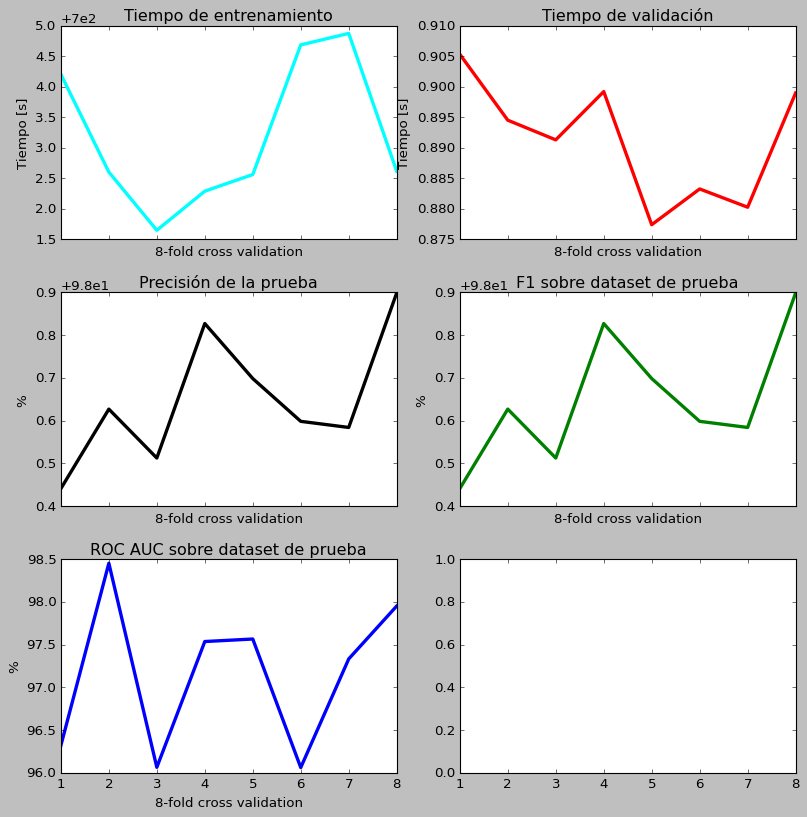

In [15]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

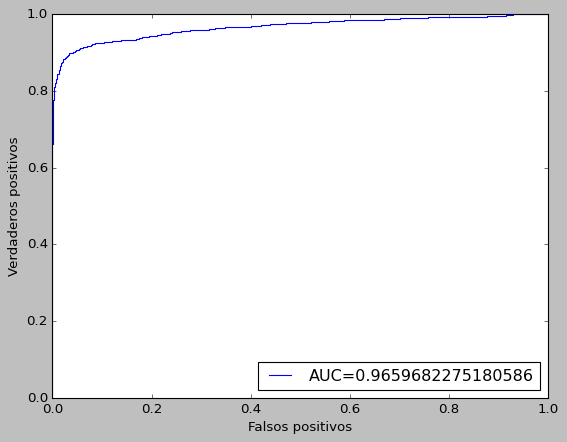

In [17]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

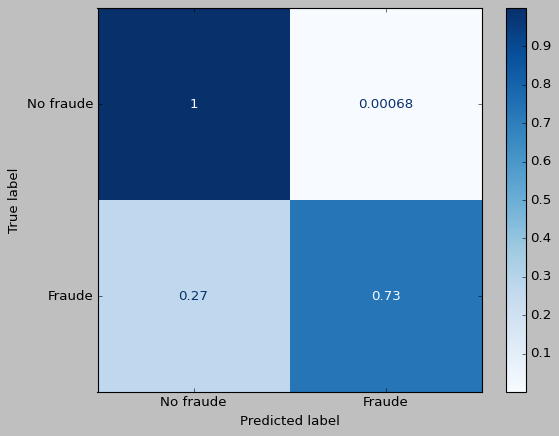

In [18]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');

# **6. GBM**

In [14]:
model1 = GradientBoostingClassifier(n_estimators=700,  max_depth=15, max_features='sqrt')
start_time = timer(None) 
model1.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 1 minutes and 14.2 seconds.


In [15]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(model1, X_train, y_train, scoring=scoring, cv=8)

In [16]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]
print(score_time)
print(fit_time)
print(test_accuracy)
print(test_f1_micro)
print(test_roc_auc)

[0.43438029 0.42676497 0.41187525 0.43531585 0.4203279  0.43981957
 0.4141643  0.43009281]
[60.7415123  60.55508614 59.26987529 60.93035817 61.139045   61.52724695
 61.038064   60.72149467]
[98.16959816959817, 98.44129844129844, 98.16959816959817, 98.48419848419849, 98.34119834119835, 98.16959816959817, 98.1981981981982, 98.45559845559846]
[98.16959816959817, 98.44129844129844, 98.16959816959817, 98.48419848419849, 98.34119834119835, 98.16959816959817, 98.1981981981982, 98.45559845559846]
[96.83038894750607, 98.11121932743555, 96.62247833419005, 96.66878590302014, 97.4851428004581, 96.4807600393186, 97.64404043683324, 97.6953981008035]


Text(68.625, 0.5, '%')

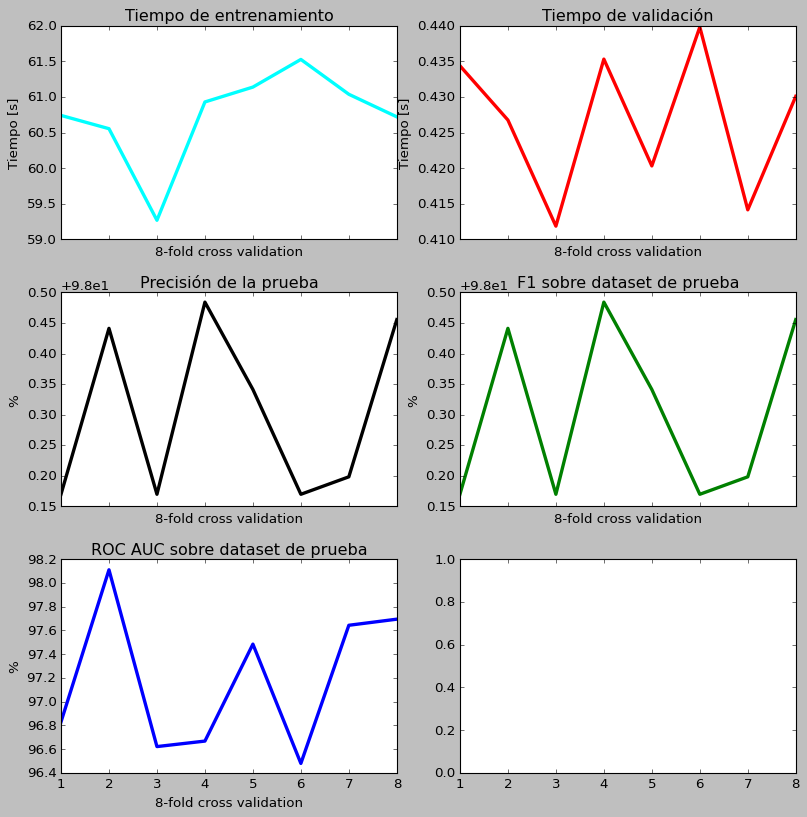

In [17]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

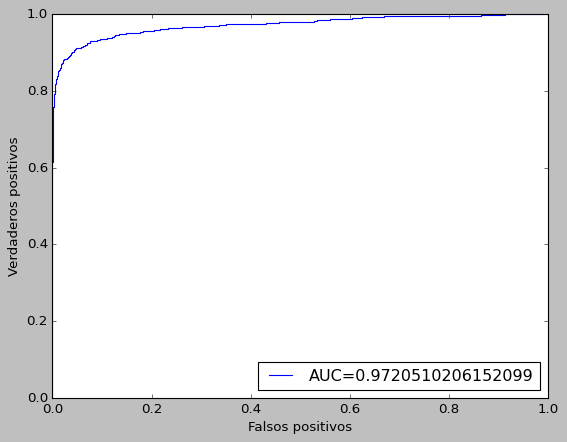

In [18]:
y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

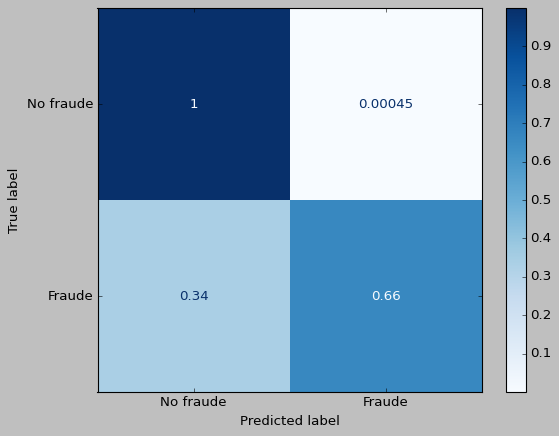

In [19]:
plot_confusion_matrix(model1, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');